## Creating a logistic regression model in Python!

In [1]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [14]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [15]:
ride_ids = ['15692']


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [16]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
print(motion_df)

https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:03.822           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.855           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.888           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.921           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.954           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.987           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.020           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 1

## Drop the NA values from the dataframe:

In [17]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print(motion_df_dropped)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.

## Create an elapsed time field to sync Smartfin data with Video Footage:

In [18]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  
ride_id UTC                                 
15692   2018-11-09 19:16:03.789        0.0  
        2018-11-09 19:16:04.053      252.5  
        2018-11-09 19:16:04.284      501.5  
        2018-11-09 19:16:04.548      753.5  
        2018-11-09 19:16:04.812     1003.5  
        2018-11-09 19:16:05.043     1253.5  
        2018-11-09 19:16:05.307     1504.5  
        2018-11-09 19:16:05.571     1755.5  
        2018-11-09 19:16:05.802     2006.5  
        2018-11-09 19:16:06.066     2258.5

## Footage sync code written by Alina:

In [19]:
#Footage sync code written by Alina: (Miulti-Column)

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = 'Footage.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #----Complex "mode" below: --------
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

motion_df_simple = label_data('Footage3.txt')
motion_df_simple.head(10)


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  FLOATING  SURFING  PADDLING  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789        0.0         0        0         0   
        2018-11-09 19:16:04.053      252.5         0        0         0   
        2018-11-09 19:16:04.284      501.5         0        0         0   
        2018-11-09 19:16:04.548      753.5         0        0         0   
        2018-11-09 19:16:04.812     1003.5         0        0         0   
        2018-11-09 19:16:05.043     1253.5         0        0         0   
        2018-11-09 19:16:05.307     1504.5         0        0         0   
        2018-11-09 19:16:05.571     1755.5         0        0         0   
        2018-11-09 19:16:05.802     2006.5         0        0         0   
        2018-11-09 19:16:06.066     2258.5         0        0         0   

                                 WALKING  
ride_id UTC                               
15692   2018-11-09 19:16:03.789        0  
        2018-11-09 19:16:04.053        0  
        2018-11-09 19:16:04.284        0  
        2018-11-09 19:16:04.548        0  
        2018-11-09 19:16:04.812        0  
        2018-11-09 19:16:05.043        0  
        2018-11-09 19:16:05.307        0  
        2018-11-09 19:16:05.571        0  
        2018-11-09 19:16:05.802        0  
        2018-11-09 19:16:06.066        0

In [20]:
motion_df_complex = label_data('Footage3.txt', 'complex')
motion_df_complex.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  PUSHING BOARD INTO WATER  \
ride_id UTC                                                            
15692   2018-11-09 19:16:03.789        0.0                         0   
        2018-11-09 19:16:04.053      252.5                         0   
        2018-11-09 19:16:04.284      501.5                         0   
        2018-11-09 19:16:04.548      753.5                         0   
        2018-11-09 19:16:04.812     1003.5                         0   
        2018-11-09 19:16:05.043     1253.5                         0   
        2018-11-09 19:16:05.307     1504.5                         0   
        2018-11-09 19:16:05.571     1755.5                         0   
        2018-11-09 19:16:05.802     2006.5                         0   
        2018-11-09 19:16:06.066     2258.5                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:16:04.812                                                  0    
        2018-11-09 19:16:05.043                                                  0    
        2018-11-09 19:16:05.307                                                  0    
        2018-11-09 19:16:05.571                                                  0    
        2018-11-09 19:16:05.802                                                  0    
        2018-11-09 19:16:06.066                                                  0    

                                 FLIP BOARD RIGHT SIDE UP  WALKING IN WATER  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:03.789                         0                 0   
        2018-11-09 1

## Concatenate multiple footage files that we have so far to create a larger mass of data samples. 

In [21]:
df1_complex = label_data('Footage.txt', 'complex')
df2_complex = label_data('Footage2.txt', 'complex')
df3_complex = label_data('Footage3.txt', 'complex')
df4_complex = label_data('Footage4.txt', 'complex')

df_concatenated = pd.concat([df1_complex, df2_complex, df3_complex, df4_complex])

print("Shape of first dataframe:", df1_complex.shape)
print("Shape of all combined dataframes:", df_concatenated.shape)

print("Printing dataframe...")
#print(df1_complex.head(10))
print(df_concatenated.head(10))

Shape of first dataframe: (21645, 51)
Shape of all combined dataframes: (86580, 88)
Printing dataframe...
                                 BOARD FLIPPED RIGHT SIDE UP  \
ride_id UTC                                                    
15692   2018-11-09 19:16:03.789                          NaN   
        2018-11-09 19:16:04.053                          NaN   
        2018-11-09 19:16:04.284                          NaN   
        2018-11-09 19:16:04.548                          NaN   
        2018-11-09 19:16:04.812                          NaN   
        2018-11-09 19:16:05.043                          NaN   
        2018-11-09 19:16:05.307                          NaN   
        2018-11-09 19:16:05.571                          NaN   
        2018-11-09 19:16:05.802                          NaN   
        2018-11-09 19:16:06.066                          NaN   

                                 BOARD FLIPPED UPSIDE DOWN (TO SYNC)  \
ride_id UTC                                          

/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [22]:
#correct IMU data
print("Calculating ...")
#make a deep copy of motion_df_labelled
df_converted = motion_df_complex.copy(deep = 'true')

#for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= -0.019141  #forwards/backwards
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141   #upside down/right side up
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141   #sideways: negative = left, positive = right
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2        #roll
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2        #yaw
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2        #pitch (flipping forwards/backwards)

motion_df_complex.head(10)  
print("Done")


Calculating ...
Done


In [23]:
df_converted.head(10)

Time     IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:03.789  1.414743e+09  -9.436513  0.918768  2.105510   
        2018-11-09 19:16:04.053  1.414743e+09  -9.819333  1.703549  1.186742   
        2018-11-09 19:16:04.284  1.414743e+09  -9.455654  1.760972  1.531280   
        2018-11-09 19:16:04.548  1.414744e+09  -8.058361  3.923905 -1.990664   
        2018-11-09 19:16:04.812  1.414744e+09 -10.221294  5.857146 -0.612512   
        2018-11-09 19:16:05.043  1.414744e+09  -8.709155  2.852009 -1.952382   
        2018-11-09 19:16:05.307  1.414744e+09  -9.072834  6.546222 -4.191879   
        2018-11-09 19:16:05.571  1.414745e+09  -6.948183  6.182543 -2.507471   
        2018-11-09 19:16:05.802  1.414745e+09   0.401961  9.761910 -8.556027   
        2018-11-09 19:16:06.066  1.414745e+09  -0.669935  5.416903 -2.526612   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:03.789   9.146341 -15.121951 -10.487805  -309.0   
        2018-11-09 19:16:04.053   4.146341  -4.390244 -11.219512  -320.0   
        2018-11-09 19:16:04.284   8.414634  -7.682927  -5.121951  -329.0   
        2018-11-09 19:16:04.548  23.414634 -11.219512  -4.512195  -330.0   
        2018-11-09 19:16:04.812 -51.341463 -28.414634 -27.926829  -325.0   
        2018-11-09 19:16:05.043 -43.292683 -45.853659 -48.414634  -337.0   
        2018-11-09 19:16:05.307 -28.536585 -64.268293 -56.707317  -311.0   
        2018-11-09 19:16:05.571   7.317073 -80.731707 -37.195122  -238.0   
        2018-11-09 19:16:05.802   9.512195 -78.414634 -18.658537  -159.0   
        2018-11-09 19:16:06.066 -13.902439 -52.439024  16.097561   -86.0   

                                 IMU M2  IMU M3  TimeDelta  \
ride_id UTC                                                  
15692   2018-11-09 19:16:03.789   209.0    39.0        0.0   
        2018-11-09 19:16:04.053   194.0    38.0      252.5   
        2018-11-09 19:16:04.284   189.0    49.0      501.5   
        2018-11-09 19:16:04.548   180.0    64.0      753.5   
        2018-11-09 19:16:04.812   161.0    97.0     1003.5   
        2018-11-09 19:16:05.043   117.0   151.0     1253.5   
        2018-11-09 19:16:05.307    25.0   217.0     1504.5   
        2018-11-09 19:16:05.571    -8.0   272.0     1755.5   
        2018-11-09 19:16:05.802   -21.0   321.0     2006.5   
        2018-11-09 19:16:06.066   -38.0   326.0     2258.5   

                                 PUSHING BOARD INTO WATER  \
ride_id UTC                                                 
15692   2018-11-09 19:16:03.789                         0   
        2018-11-09 19:16:04.053                         0   
        2018-11-09 19:16:04.284                         0   
        2018-11-09 19:16:04.548                         0   
        2018-11-09 19:16:04.812                         0   
        2018-11-09 19:16:05.043                         0   
        2018-11-09 19:16:05.307                         0   
        2018-11-09 19:16:05.571                         0   
        2018-11-09 19:16:05.802                         0   
        2018-11-09 19:16:06.066                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:16:04.812                                                  0    
        2018-11-09 19:16:05.043                                                 

In [24]:
list(df_converted)

['Time',
 'IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'TimeDelta',
 'PUSHING BOARD INTO WATER',
 'SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)',
 'FLIP BOARD RIGHT SIDE UP',
 'WALKING IN WATER',
 'PUSH-OFF',
 'PADDLING INTO WAVES',
 'SIT-UP',
 'FLOATING',
 "TURNING TO SURFER'S LEFT",
 'LAY-DOWN',
 'PADDLING FOR A WAVE',
 'POP-UP',
 'SURFING',
 'STEP-OFF',
 "TURNING TO SURFER'S RIGHT",
 'SIT-BACK',
 'OFF-BOARD',
 'PADDLING',
 'WIPE-OUT',
 'PULL-BACK LEASH',
 'PADDLING FOR POSITION',
 'NEW',
 'DONE, OUT OF WATER',
 'WALKING OUT OF WATER']

In [25]:
##Rename the "Sync" label to "Board upside down" label:
df_converted.rename(columns={'SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)': 'BOARD UPSIDE DOWN'}, inplace=True)

## Drop data columns that we don't care about predicting/visualizing:
df_converted = df_converted.drop(columns=['DONE, OUT OF WATER'])
df_converted = df_converted.drop(columns=["NEW"])
df_converted = df_converted.drop(columns=["PUSHING BOARD INTO WATER", "PADDLING"])
df_converted = df_converted.drop(columns=["FLIP BOARD RIGHT SIDE UP", "NEW", "DONE, OUT OF WATER", "PUSHING BOARD INTO WATER", "PADDLING"])
#df_converted = df_converted.drop(columns!=["SURFING, FLOATING, PADDLING INTO WAVES, PADDLING FOR A WAVE, PADDLING FOR POSITION, PADDLING"])



KeyError: "['NEW' 'DONE, OUT OF WATER' 'PUSHING BOARD INTO WATER' 'PADDLING'] not found in axis"

In [ ]:
list(df_converted)

In [26]:
##Checking to see how many of each instance exist in the dataframe: 
## Count number of instances of just "paddling" from the data: 
num = 0
for val in df_converted["FLOATING"]:
    if val == 1:
        num +=1
    
print(num)

4367


## Butterworth Bandpass Filter

Plotting:


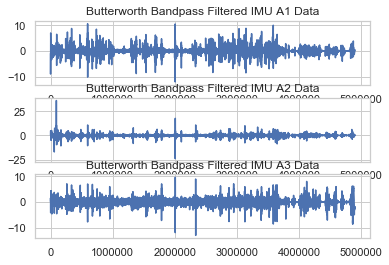

The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...


In [27]:
## Apply a Filter to the signals to reduce noise:
## Butter Filters for Bandpass:
%matplotlib inline
from scipy import signal
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y




# Define the sample rate and the Low and High Cutoff frequencies
#fs = 30
fs = 5
lowcut = 0.0333
highcut = 1.5


#Get each IMU column from the dataframe: 
#array = df_converted.values

time_array = df_converted['TimeDelta'].values
imua1_array = df_converted['IMU A1'].values
imua2_array = df_converted['IMU A2'].values
imua3_array = df_converted['IMU A3'].values

imug1_array = df_converted['IMU G1'].values
imug2_array = df_converted['IMU G2'].values
imug3_array = df_converted['IMU G3'].values

imum1_array = df_converted['IMU M1'].values
imum2_array = df_converted['IMU M2'].values
imum3_array = df_converted['IMU M3'].values


##Graphing the bandpass filters:
#A bandpass filter is both a highpass and a lowpass filter combined.
butter_lfilter_a1 = butter_bandpass_lfilter(imua1_array, lowcut, highcut, fs, order=5)
butter_lfilter_a2 = butter_bandpass_lfilter(imua2_array, lowcut, highcut, fs, order=5)
butter_lfilter_a3 = butter_bandpass_lfilter(imua3_array, lowcut, highcut, fs, order=5)



#butter_filtfilt = butter_bandpass_filtfilt(dacc_array1, lowcut, highcut, fs, order=5)



#Can change num_elems to 1000 for example if you only want to graph the first 1000 elems:
num_elems = len(time_array)

print("Plotting:")
plt.figure(1)
plt.subplot(311)
plt.plot(time_array[:num_elems], butter_lfilter_a1[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A1 Data")

plt.subplot(312)
plt.plot(time_array[:num_elems], butter_lfilter_a2[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A2 Data")

plt.subplot(313)
plt.plot(time_array[:num_elems], butter_lfilter_a3[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A3 Data")

#Save as file
file_name = "butter_worth_graphs"
pdf_string = '.jpg'
file_name += pdf_string
plt.savefig(file_name)

#Show in line
plt.show()

print("The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...")

## Update dataframe with the filtered values, then do another labelled plot of all IMU values: 

## SVM on Raw data values: 

In [28]:
#Following this tutorial: 
#https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/

#Also, make sure that the df_converted that gets copied does not get changed by the filtering methods being tested.
dataset = df_converted.copy()

print(dataset.shape)
print(dataset.head(5))

(21645, 31)
                                         Time     IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:03.789  1.414743e+09  -9.436513  0.918768  2.105510   
        2018-11-09 19:16:04.053  1.414743e+09  -9.819333  1.703549  1.186742   
        2018-11-09 19:16:04.284  1.414743e+09  -9.455654  1.760972  1.531280   
        2018-11-09 19:16:04.548  1.414744e+09  -8.058361  3.923905 -1.990664   
        2018-11-09 19:16:04.812  1.414744e+09 -10.221294  5.857146 -0.612512   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:03.789   9.146341 -15.121951 -10.487805  -309.0   
        2018-11-09 19:16:04.053   4.146341  -4.390244 -11.219512  -320.0   
        2018-11-09 19:16:04.284   8.414634  -7.682927  -5.121951  -329.0   
        2018-11-09 19:16:04.548  23.414634 -11.

In [29]:
#Divide the data into attributes and labels, then training and testing sets. 

#Link which explains below: 
#https://stackoverflow.com/questions/37512079/python-pandas-why-does-df-iloc-1-values-for-my-training-data-select-till
X = dataset.iloc[:, :11].values  #selects all attribute columns
y = dataset.loc[:,'FLOATING'].values   #selects the column specified (ex: 'FLOATING')
print("X.shape:", X.shape)
print("y.shape:", y.shape)

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("first few y_train values:", y_train[0:10])
print("first few y_test values:", y_test[0:10])

X.shape: (21645, 11)
y.shape: (21645,)
x_train shape: (17316, 11)
y_train shape: (17316,)
x_test shape: (4329, 11)
y_test shape: (4329,)
first few y_train values: [0 0 0 0 0 0 0 0 0 0]
first few y_test values: [0 0 0 0 0 0 1 0 0 0]


In [30]:
simple_multi_dataset = pd.read_csv('simple_multi_dataset.csv')

X = simple_multi_dataset.iloc[:, 2:-1].values  #selects everything until the last column listed

y = simple_multi_dataset.iloc[:, -1].values   #selects the last column 
print("X.shape:", X.shape)
print("y.shape:", y.shape)

print("y:", y)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

FileNotFoundError: File b'simple_multi_dataset.csv' does not exist

# Balancing Data with SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Balancing Data with ADASYN

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

simple_multi_dataset.head(10)

In [ ]:
#Training the algorithm: 
#The fit method is called to train the algorithm on the training data, which is passed as a parameter to the fit method.

print("Running SVM classifier.")


#******Note:**********
#** Also may need to scale the signals? So they influence the classifier the same....**
# https://stats.stackexchange.com/questions/65094/why-scaling-is-important-for-the-linear-svm-classification



#There are different types of kernel for SVMs, here we are using the "linear" kernel to see how it performs.
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train) 

#Making predictions: use the predict method of the SVC class
y_pred = svclassifier.predict(X_test)  


#This takes a really long time to run!
print("Done.")

In [ ]:
#Evaluating the algorithm, using a confusion matrix: 
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 